## !!! Data Pre-processing !!!

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

### Loading raw data
* Loading imported data from ORBDA. Data was previously saved to csv from postgresql database. 
* Columns are renamed to match the names in the paper. 
* Filtered data with the required 10 target labels.

In [9]:
# Due to the size of the data, only a sample data file "data-nephrology-s.csv.gz" is available in the repo. 
# Full data can be  downloaded from ORBDA website. 
# Pre-processed output of the full data is avialble under "processed-data". 
data_all = pd.read_csv("./raw-data/data-nephrology.csv.gz")

In [10]:
data = data_all[["ap_cnspcn", "ap_cmp", "an_hcv", "an_hiv", "an_hbsag", "ap_nuidade", "ap_coduni", "ap_pripal", \
                 "ap_motsai", "estado", "an_tru", "an_intfis", "an_diures", "ap_cidpri"]]

In [11]:
data = data.rename(columns={"ap_cnspcn": "owner_id", "ap_cmp": "dt", "an_hcv": "HIC_antibodies", "an_hiv": "HIV", \
                    "an_hbsag": "HbsAg", "ap_nuidade": "Age", "ap_coduni": "Hc_u", "ap_pripal": "Procedure", \
                    "ap_motsai": "r_f_d", "estado": "State", "an_tru": "u_red_r", "an_intfis": "v_f_amount", \
                    "an_diures": "Vlm", "ap_cidpri": "label"})

In [12]:
data.head()

,owner_id,dt,HIC_antibodies,HIV,HbsAg,Age,Hc_u,Procedure,r_f_d,State,u_red_r,v_f_amount,Vlm,label
0,0a4d84042d1c22d14653389dc54db7bd80fd48478c7052...,200805,N,N,N,49,1e094d3407818ed6,305010107,21,PR,0,0,,N189
1,df9541344c027bb8344464f7c7665eb8948463ac48c46f...,200805,N,N,N,9,0a1df836bb7463e3,305010166,21,PR,0000,00,,N004
2,0a4d84042d1c22d12d3892d969185609ace7712bc13865...,200805,N,N,N,26,db56c1be4286df45,305010107,21,PR,68,0,,N180
3,0a4d84042d1c22d14f81f4cea79139f1a45cb047d3ea60...,200805,N,N,N,51,c1cce71139901cca,305010107,21,PR,69,0,,N180
4,066dc1f1bf291e96293fb2f9f74e8ff08c07861890352c...,200805,N,N,N,63,bfcd38cea31765c0,305010107,21,PR,69,1,,N180


In [13]:
data["label"] = data["label"].str.strip()

In [14]:
# E10.2 Type 1 diabetes mellitus with renal complications  
# E14.2 Unspecified diabetes mellitus with renal complications
# I10 Essential (primary) hypertension 
# I12.0 Hypertensive renal disease with renal failure  
# N03.9 Chronic nephritic syndrome : unspecified  
# N08.3 Glomerular disorders in diabetes mellitus  
# N08.8 Glomerular disorders in other diseases classified elsewhere  
# N18 Chronic kidney disease  
# N18.8 Other chronic kidney disease
# N18.9 Chronic kidney disease, unspecified  
labels = ["E102", "E142", "I10", "I120", "N039", "N083", "N088", "N180", "N188", "N189"]

In [15]:
data_f = data[data["label"].isin(labels)]

### Converting (owner_id) to integer patient id (p_id)

In [16]:
owner_ids = data_f["owner_id"].unique()

In [17]:
print(len(owner_ids))
print(owner_ids[0])

227037
0a4d84042d1c22d14653389dc54db7bd80fd48478c70522e57850c05b5fb5559


In [18]:
data_f["owner_id"] = data_f["owner_id"].astype('category')
data_f["p_id"] = data_f["owner_id"].cat.codes

In [19]:
data_f = data_f.drop(columns=['owner_id'])

In [20]:
data_f.head()

,dt,HIC_antibodies,HIV,HbsAg,Age,Hc_u,Procedure,r_f_d,State,u_red_r,v_f_amount,Vlm,label,p_id
0,200805,N,N,N,49,1e094d3407818ed6,305010107,21,PR,0,0,,N189,52685
2,200805,N,N,N,26,db56c1be4286df45,305010107,21,PR,68,0,,N180,37378
3,200805,N,N,N,51,c1cce71139901cca,305010107,21,PR,69,0,,N180,58764
4,200805,N,N,N,63,bfcd38cea31765c0,305010107,21,PR,69,1,,N180,2839
5,200805,N,N,N,54,bfcd38cea31765c0,305010107,21,PR,60,0,,N180,20019


### Data type conversions and cleanup 

In [21]:
def to_bool(x):
    if x == 'N':
        x = 0
    else:
        x = 1
    return x

In [22]:
def trim(x):
    x = x.strip(' ')
    x = x.lstrip('0')
    if len(x) == 0:
        x = -1
    else:
        if ',' in x:
            #print(x)
            tokens = x.strip(',')
            if len(tokens) > 0:
                x = tokens[0]
            else:
                x = -1
        if x == '-':
            x = -1
        try:
            x = int(x)
        except:
            #print(x)
            x = -1
    return(x)

In [23]:
data_f["HIC_antibodies"] = data_f["HIC_antibodies"].apply(to_bool)
data_f["HIV"] = data_f["HIV"].apply(to_bool)
data_f["HbsAg"] = data_f["HbsAg"].apply(to_bool)

In [24]:
data_f['Vlm'] = data_f['Vlm'].apply(trim)
data_f['v_f_amount'] = data_f['v_f_amount'].apply(trim)
data_f['u_red_r'] = data_f['u_red_r'].apply(trim)

data_f['Vlm'] = data_f['Vlm'].astype(int)
data_f['v_f_amount'] = data_f['v_f_amount'].astype(int)
data_f['u_red_r'] = data_f['u_red_r'].astype(int)

### Dropping rows with null values for "Urea Reduction Rate", "Venous Fistula Ammount" & "Volume"

In [25]:
data_f = data_f.replace(-1, np.nan)

In [26]:
data_f.head()

,dt,HIC_antibodies,HIV,HbsAg,Age,Hc_u,Procedure,r_f_d,State,u_red_r,v_f_amount,Vlm,label,p_id
0,200805,0,0,0,49,1e094d3407818ed6,305010107,21,PR,NaN,NaN,NaN,N189,52685
2,200805,0,0,0,26,db56c1be4286df45,305010107,21,PR,68.0,NaN,NaN,N180,37378
3,200805,0,0,0,51,c1cce71139901cca,305010107,21,PR,69.0,NaN,NaN,N180,58764
4,200805,0,0,0,63,bfcd38cea31765c0,305010107,21,PR,69.0,1.0,NaN,N180,2839
5,200805,0,0,0,54,bfcd38cea31765c0,305010107,21,PR,60.0,NaN,NaN,N180,20019


In [27]:
d_f = data_f[(~data_f["Vlm"].isna()) | (~data_f["v_f_amount"].isna()) | (~data_f["u_red_r"].isna())]

### Total number of records for each class 

In [28]:
for l in labels:
    d_f_l = d_f[d_f["label"] == l]
    print(f"{l}:{len(d_f_l)}")

E102:968
E142:1809
I10:4224
I120:14365
N039:5310
N083:4480
N088:1381
N180:3333730
N188:3824
N189:23294


### Total number of unique patients 

In [29]:
pids = d_f["p_id"].unique()
print(len(pids))

184123


### Filling missing values using interpolation. 
* Each patient have multiple visits. Interpolation is applied for each patient one at a time by grouping patient records.
* For each patient visits are sorted by date(dt) before applying interpolation.
* First "polynomial" interpolation is applied followed by "linear" for missing edges. 

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

df_all = []
for idx, p in enumerate(pids):
    p_df = d_f[(d_f["p_id"] == p)]
    p_df = p_df.sort_values(by=['dt'])
    try:
        p_df = p_df.interpolate(method='polynomial', order=2)
    except:
        pass
    p_df = p_df.interpolate(method='linear', limit_direction='forward', axis=0)
    p_df = p_df.interpolate(method='linear', limit_direction='backward', axis=0)
    p_df = p_df.fillna(0)
    df_all.append(shuffle(p_df))
    
df_in = pd.concat(df_all, axis=0, ignore_index=True, sort=False)

In [31]:
print(len(df_in))

3393385


In [32]:
df_in.head()

,dt,HIC_antibodies,HIV,HbsAg,Age,Hc_u,Procedure,r_f_d,State,u_red_r,v_f_amount,Vlm,label,p_id
0,201003,0,0,0,28,db56c1be4286df45,305010107,21,PR,65.0,0.0,0.0,N180,37378
1,200903,0,0,0,27,db56c1be4286df45,305010107,21,PR,57.0,0.0,0.0,N180,37378
2,201102,0,0,0,29,db56c1be4286df45,305010107,21,PR,66.0,0.0,0.0,N180,37378
3,200806,0,0,0,26,db56c1be4286df45,305010107,21,PR,70.0,0.0,0.0,N180,37378
4,201009,0,0,0,28,db56c1be4286df45,305010107,21,PR,56.0,0.0,0.0,N180,37378


### Saving interpolated data and helper method to load data from the file and inspect data

In [33]:
# df_in.to_csv("processed-data/data-interpolated.csv.gz", compression="gzip")

In [55]:
def load_csv(file_name):
    df_s_in = pd.read_csv(file_name)
    print(df_s_in.columns)
    return df_s_in.drop(["Unnamed: 0"], axis=1)

In [57]:
df_in = load_csv("processed-data/data-interpolated.csv.gz")

Index(['Unnamed: 0', 'dt', 'HIC_antibodies', 'HIV', 'HbsAg', 'Age', 'Hc_u',
       'Procedure', 'r_f_d', 'State', 'u_red_r', 'v_f_amount', 'Vlm', 'label',
       'p_id'],
      dtype='object')


In [36]:
len(df_in)

3393385

In [37]:
df_in.head()

,dt,HIC_antibodies,HIV,HbsAg,Age,Hc_u,Procedure,r_f_d,State,u_red_r,v_f_amount,Vlm,label,p_id
0,201003,0,0,0,28,db56c1be4286df45,305010107,21,PR,65.0,0.0,0.0,N180,37378
1,200903,0,0,0,27,db56c1be4286df45,305010107,21,PR,57.0,0.0,0.0,N180,37378
2,201102,0,0,0,29,db56c1be4286df45,305010107,21,PR,66.0,0.0,0.0,N180,37378
3,200806,0,0,0,26,db56c1be4286df45,305010107,21,PR,70.0,0.0,0.0,N180,37378
4,201009,0,0,0,28,db56c1be4286df45,305010107,21,PR,56.0,0.0,0.0,N180,37378


In [38]:
def get_patient_data(df, p_id):
    return df[df["p_id"] == p_id]

In [39]:
get_patient_data(d_f, 1604).head()

,dt,HIC_antibodies,HIV,HbsAg,Age,Hc_u,Procedure,r_f_d,State,u_red_r,v_f_amount,Vlm,label,p_id
1922,201011,0,0,0,55,71d90e835af8b296,305010107,21,MG,59.0,NaN,NaN,N180,1604
16648,201203,0,0,0,56,71d90e835af8b296,305010107,21,MG,64.0,NaN,NaN,N180,1604
274194,201110,0,0,0,56,71d90e835af8b296,305010107,21,MG,NaN,NaN,2500.0,N180,1604
753988,201002,0,0,0,54,71d90e835af8b296,305010107,21,MG,70.0,NaN,NaN,N180,1604
768198,201106,0,0,0,55,71d90e835af8b296,305010107,21,MG,64.0,NaN,NaN,N180,1604


In [40]:
get_patient_data(df_in, 1604).head()

,dt,HIC_antibodies,HIV,HbsAg,Age,Hc_u,Procedure,r_f_d,State,u_red_r,v_f_amount,Vlm,label,p_id
34265,200911,0,0,0,54,71d90e835af8b296,305010107,21,MG,77.000000,0.0,4041.906961,N180,1604
34266,201104,0,0,0,55,71d90e835af8b296,305010107,21,MG,145.550534,0.0,2500.000000,N180,1604
34267,201002,0,0,0,54,71d90e835af8b296,305010107,21,MG,70.000000,0.0,2300.270664,N180,1604
34268,201011,0,0,0,55,71d90e835af8b296,305010107,21,MG,59.000000,0.0,1925.723634,N180,1604
34269,200912,0,0,0,54,71d90e835af8b296,305010107,21,MG,70.000000,0.0,3933.364369,N180,1604


### Normalizing data using min-max scaler. 
Normalizing the following columns across all the patients and visits 
* Age
* Reason for Discharge
* Urea Reduction Rate
* Venous Fistula Ammount
* Volume 

In [41]:
def normalize(v):
    mm_scaler = preprocessing.MinMaxScaler()
    v_scaled = mm_scaler.fit_transform(v)
    return v_scaled

df_v = df_in.values
age_v = df_v[:, 4:5]
rfd_v = df_v[:, 7:8]
urr_v = df_v[:, 9:10]
vfm_v = df_v[:, 10:11]
vlm_v = df_v[:, 11:12]

df_in["Age"] = normalize(age_v)
df_in["r_f_d"] = normalize(rfd_v)
df_in["u_red_r"] = normalize(urr_v)
df_in["v_f_amount"] = normalize(vfm_v)
df_in["Vlm"] = normalize(vlm_v)

In [42]:
df_in.head()

,dt,HIC_antibodies,HIV,HbsAg,Age,Hc_u,Procedure,r_f_d,State,u_red_r,v_f_amount,Vlm,label,p_id
0,201003,0,0,0,0.3500,db56c1be4286df45,305010107,0.25,PR,0.596637,0.553054,0.297873,N180,37378
1,200903,0,0,0,0.3375,db56c1be4286df45,305010107,0.25,PR,0.596637,0.553054,0.297873,N180,37378
2,201102,0,0,0,0.3625,db56c1be4286df45,305010107,0.25,PR,0.596637,0.553054,0.297873,N180,37378
3,200806,0,0,0,0.3250,db56c1be4286df45,305010107,0.25,PR,0.596637,0.553054,0.297873,N180,37378
4,201009,0,0,0,0.3500,db56c1be4286df45,305010107,0.25,PR,0.596637,0.553054,0.297873,N180,37378


### One-hot-encoding of "Procedure" and "State" columns 
We are not encoding "Hc_u" which is the unit identifier. There are over 700 units which is exploding the data. Unit will not have significant impact on the health status of the patient. The column is dropped before picking the final features 

In [43]:
# df_in = pd.get_dummies(df_in, columns=["Hc_u"])
df_in = pd.get_dummies(df_in, columns=["Procedure"])
df_in = pd.get_dummies(df_in, columns=["State"])

In [44]:
p_count = len(df_in["p_id"].unique())
print(p_count)

184123


In [45]:
df_in.head()

,dt,HIC_antibodies,HIV,HbsAg,Age,Hc_u,r_f_d,u_red_r,v_f_amount,Vlm,...,State_PR,State_RJ,State_RN,State_RO,State_RR,State_RS,State_SC,State_SE,State_SP,State_TO
0,201003,0,0,0,0.3500,db56c1be4286df45,0.25,0.596637,0.553054,0.297873,...,1,0,0,0,0,0,0,0,0,0
1,200903,0,0,0,0.3375,db56c1be4286df45,0.25,0.596637,0.553054,0.297873,...,1,0,0,0,0,0,0,0,0,0
2,201102,0,0,0,0.3625,db56c1be4286df45,0.25,0.596637,0.553054,0.297873,...,1,0,0,0,0,0,0,0,0,0
3,200806,0,0,0,0.3250,db56c1be4286df45,0.25,0.596637,0.553054,0.297873,...,1,0,0,0,0,0,0,0,0,0
4,201009,0,0,0,0.3500,db56c1be4286df45,0.25,0.596637,0.553054,0.297873,...,1,0,0,0,0,0,0,0,0,0


### Inspecting and clipping visits 
Visualizing number of visists to determine the optimal number of visits to use. We need to pad the visits so that each patient have the same number of visits. Based on below anaysis, number of visits are clipped to the most recent 40. 

In [46]:
visits_count = df_in.groupby("p_id").count().reset_index()["dt"]

Text(0, 0.5, 'visits')

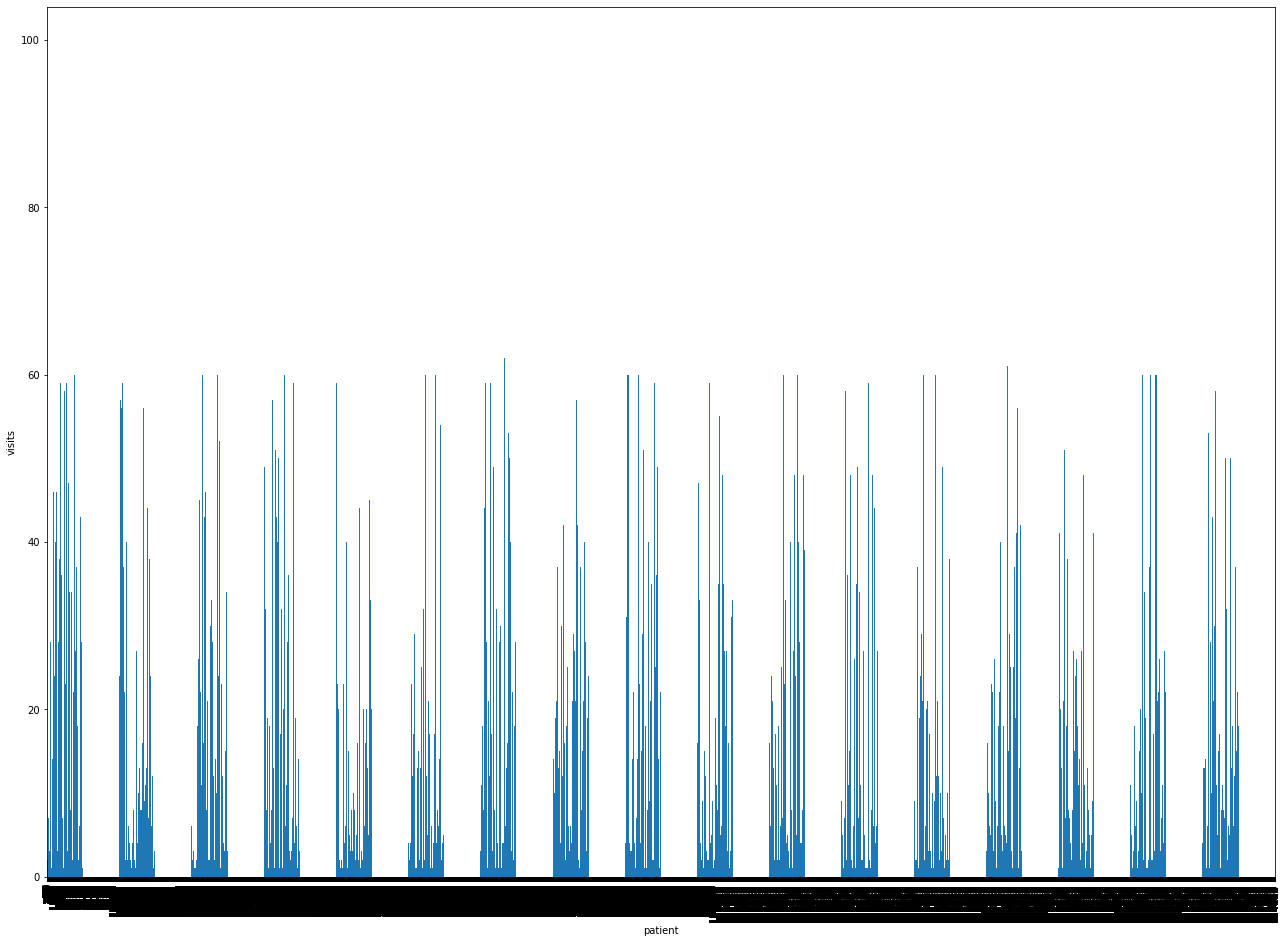

In [12]:
# # This take really long time to plot. Just keeping it commented out to avoid any accidental runs
# ax = visits_count.plot(x ='index', y='dt', kind = 'bar', figsize=(22, 16))
# ax.set_xlabel("patient")
# ax.set_ylabel("visits")

In [47]:
v_size = visits_count.max()
print(v_size)

99


In [48]:
df_in.shape

(3393385, 46)

In [49]:
df_in = df_in.drop(['dt', 'Hc_u'], axis=1)

In [64]:
n_features = df_in.shape[1]
print(n_features)

44


In [65]:
v_size_clipped = 40

#### At this point we have completed the normlization. Saving data to csv to reuse later 

In [53]:
# df_in.to_csv("processed-data/data-normlized.csv.gz", compression="gzip")

In [69]:
df_in = load_csv("processed-data/data-normlized.csv.gz")

Index(['Unnamed: 0', 'HIC_antibodies', 'HIV', 'HbsAg', 'Age', 'r_f_d',
       'u_red_r', 'v_f_amount', 'Vlm', 'label', 'p_id', 'Procedure_305010026',
       'Procedure_305010069', 'Procedure_305010085', 'Procedure_305010107',
       'Procedure_305010115', 'Procedure_305010166', 'Procedure_305010182',
       'State_AC', 'State_AL', 'State_AM', 'State_AP', 'State_BA', 'State_CE',
       'State_DF', 'State_ES', 'State_GO', 'State_MA', 'State_MG', 'State_MS',
       'State_MT', 'State_PA', 'State_PB', 'State_PE', 'State_PI', 'State_PR',
       'State_RJ', 'State_RN', 'State_RO', 'State_RR', 'State_RS', 'State_SC',
       'State_SE', 'State_SP', 'State_TO'],
      dtype='object')


### Padding visits for the patients to make sure all the patients have same number of visits. 
We are dropping patient id (p_id) and target label (label) in the process. So, reducing the feature count by 2.

After this process, we have 184123 patients with 40 visits and 42 features for each visit. 

In [70]:
v_features = n_features - 2
X = np.zeros((p_count, v_size_clipped, v_features))
Y = []
for idx, p_id in enumerate(df_in["p_id"].unique()):
    p_v = df_in[(df_in["p_id"] == p_id)]
    p_y = list(p_v['label'])[-1]
    p_x = p_v.drop(['p_id', 'label'], axis=1).to_numpy()
    pad_len = v_size_clipped - len(p_x)
    if pad_len > 0:
        pad_arr = np.zeros((pad_len, v_features))
        p_x = np.vstack([p_x, pad_arr])
    else:
        p_x = p_x[-v_size_clipped:]
    X[idx] = p_x
    Y.append(p_y)

In [71]:
print(len(Y))
print(len(X))
print(set(Y))

184123
184123
{'N039', 'N189', 'N088', 'I120', 'E142', 'N083', 'E102', 'N188', 'N180', 'I10'}


In [72]:
print(X.shape)
print(len(Y))

(184123, 40, 42)
184123


### Saving the final padded data and the target labels. 

In [73]:
# torch.save(X, "processed-data/p_x.pt")
# torch.save(Y, "processed-data/p_y.pt")

### Number of patients in each target class

In [74]:
for l in set(Y):
    print(f"{l}:", len(np.where(np.array(Y) == l)[0]))

N039: 316
N189: 2690
N088: 129
I120: 1189
E142: 178
N083: 314
E102: 100
N188: 307
N180: 178540
I10: 360


### One hot encoding target labels

In [75]:
y_labels = list(set(Y))
Y_oh = np.zeros((len(Y), len(y_labels)))
for idx, y in enumerate(Y):
    Y_oh[idx][y_labels.index(y)] = 1

In [76]:
print(Y_oh.shape)
Y_oh

(184123, 10)


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

### Saving one hot encoded labels. 

In [77]:
# torch.save(Y_oh, "processed-data/p_y_oh.pt")